In [1]:
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors

from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

import pickle
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
Epochs = 10
in_sample = "data/test.pkl"
out_file = "results/test.torch"
out_path = "plots/train"

In [3]:
print("Loading Data into memory...")
data = pickle.load( open( in_sample , "rb" ) )
X_train, y_train, X_val, y_val, X_test, y_test = data

Loading Data into memory...


In [4]:
class Encoder(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(Encoder, self).__init__()
        self.pre_norm_Q = nn.LayerNorm(embed_dim)
        self.pre_norm_K = nn.LayerNorm(embed_dim)
        self.pre_norm_V = nn.LayerNorm(embed_dim)
        self.attention = nn.MultiheadAttention(embed_dim,num_heads=num_heads,batch_first=True, dropout=0.25)
        self.post_norm = nn.LayerNorm(embed_dim)
        self.out = nn.Linear(embed_dim,embed_dim)
    def forward(self, Query, Key, Value):
        Query = self.pre_norm_Q(Query)
        Key = self.pre_norm_K(Key)
        Value = self.pre_norm_V(Value)
        context, weights = self.attention(Query, Key, Value)
        context = self.post_norm(context)
        latent = Query + context
        tmp = F.gelu(self.out(latent))
        latent = latent + tmp
        return latent, weights

In [5]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.embed_dim = 256
        self.num_heads = 8
        self.num_jet_feats = 4
        self.num_trk_feats = 6

        self.jet_initializer = nn.Linear(self.num_jet_feats, self.embed_dim)
        self.jet_trk_initializer = nn.Linear(self.num_trk_feats, self.embed_dim)
        self.trk_initializer = nn.Linear(self.num_trk_feats, self.embed_dim)

        # Track Encoder Stack
        self.trk_encoder1 = Encoder(self.embed_dim, self.num_heads)
        self.trk_encoder2 = Encoder(self.embed_dim, self.num_heads)
        self.trk_encoder3 = Encoder(self.embed_dim, self.num_heads)
        self.jet_postprocess = nn.Linear(self.embed_dim*2, self.embed_dim)

        # All Track Encoder Stack
        self.all_trk_encoder1 = Encoder(self.embed_dim, self.num_heads)
        self.all_trk_encoder2 = Encoder(self.embed_dim, self.num_heads)
        self.all_trk_encoder3 = Encoder(self.embed_dim, self.num_heads)

        # Cross Encoder Stack
        self.cross_encoder1 = Encoder(self.embed_dim, self.num_heads)
        self.cross_encoder2 = Encoder(self.embed_dim, self.num_heads)
        self.cross_encoder3 = Encoder(self.embed_dim, self.num_heads)

        # Jet Encoder Stack
        self.jet_encoder1 = Encoder(self.embed_dim, self.num_heads)
        self.jet_encoder2 = Encoder(self.embed_dim, self.num_heads)
        self.jet_encoder3 = Encoder(self.embed_dim, self.num_heads)

        # Regression Task
        self.regression = nn.Linear(self.embed_dim, 2)
        
        # BCE Task
        self.classification = nn.Linear(self.embed_dim, 1)

    def forward(self, jets, jet_trks, trks):
        # Feature preprocessing layers
        jet_init = F.relu(self.jet_initializer(jets))
        jet_trk_init = F.relu(self.jet_trk_initializer(jet_trks))
        trk_init = F.relu(self.trk_initializer(trks))

        # Calculate aggregated tracks using attention
        jet_trk_embedding, trk_weights = self.trk_encoder1(jet_trk_init, jet_trk_init, jet_trk_init)
        jet_trk_embedding, trk_weights = self.trk_encoder2(jet_trk_embedding, jet_trk_embedding, jet_trk_embedding)
        jet_trk_embedding, trk_weights = self.trk_encoder3(jet_trk_embedding, jet_trk_embedding, jet_trk_embedding)

        # Generate meaningful jet_embedding using info from trk_aggregated
        jet_trk_aggregated = jet_trk_embedding.sum(dim=1)
        jet_embedding = torch.cat((jet_init, jet_trk_aggregated),1)
        jet_embedding = F.relu(self.jet_postprocess(jet_embedding))

        # All Track Attention
        all_trk_embedding, all_trk_weights = self.all_trk_encoder1(trk_init, trk_init, trk_init)
        all_trk_embedding, all_trk_weights = self.all_trk_encoder2(all_trk_embedding, all_trk_embedding, all_trk_embedding)
        all_trk_embedding, all_trk_weights = self.all_trk_encoder3(all_trk_embedding, all_trk_embedding, all_trk_embedding)

        # Cross Attention
        jet_embedding, cross_weights = self.cross_encoder1(jet_embedding, all_trk_embedding, all_trk_embedding)
        jet_embedding, cross_weights = self.cross_encoder2(jet_embedding, all_trk_embedding, all_trk_embedding)
        jet_embedding, cross_weights = self.cross_encoder3(jet_embedding, all_trk_embedding, all_trk_embedding)

        # Update embeddings of jets in the contex of entire event
        jet_embedding, jet_weights = self.jet_encoder1(jet_embedding, jet_embedding, jet_embedding)
        jet_embedding, jet_weights = self.jet_encoder2(jet_embedding, jet_embedding, jet_embedding)
        jet_embedding, jet_weights = self.jet_encoder3(jet_embedding, jet_embedding, jet_embedding)

        # Get Jet output
        jet_output = F.sigmoid(self.regression(jet_embedding))
        
        # Get Track output
        trk_output = F.sigmoid(self.classification(all_trk_embedding))

        return jet_output, trk_output

In [6]:
# Get Instance of the model
model = Model()
print(model)
print()

# Pass some data to the model and print outputs
Event_no = 0
Jets    = 0
Trk_Jet = 1
Trks     = 2

jet_pred, trk_pred = model(X_train[Event_no][Jets],X_train[Event_no][Trk_Jet],X_train[Event_no][Trks])

# Evaluate the loss
jet_loss_fn = nn.MSELoss()
trk_loss_fn = nn.BCELoss()

print(jet_loss_fn(jet_pred,y_train[Event_no][0]))
print(trk_loss_fn(trk_pred,y_train[Event_no][1]))

Model(
  (jet_initializer): Linear(in_features=4, out_features=256, bias=True)
  (jet_trk_initializer): Linear(in_features=6, out_features=256, bias=True)
  (trk_initializer): Linear(in_features=6, out_features=256, bias=True)
  (trk_encoder1): Encoder(
    (pre_norm_Q): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (pre_norm_K): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (pre_norm_V): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
    )
    (post_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (out): Linear(in_features=256, out_features=256, bias=True)
  )
  (trk_encoder2): Encoder(
    (pre_norm_Q): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (pre_norm_K): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (pre_norm_V): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (atte

In [7]:
print("Trainable Parameters :", sum(p.numel() for p in model.parameters() if p.requires_grad))

Trainable Parameters : 4109059


In [8]:
### Define Training Loop
def train(model, optimizer, X_train, y_train, X_val, y_val, epochs=40):

    combined_history = []

    num_train = len(X_train)
    num_val = len(X_val)

    step_size=15
    gamma=0.1
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    for e in range(epochs):
        model.train()
        cumulative_loss_train = 0

        for i in range(num_train):
            optimizer.zero_grad()

            jet_pred, trk_pred = model(X_train[i][0].to(device), X_train[i][1].to(device), X_train[i][2].to(device))

            jet_loss=jet_loss_fn(jet_pred, y_train[i][0].to(device))
            trk_loss=trk_loss_fn(trk_pred, y_train[i][1].to(device))

            loss = jet_loss+trk_loss

            loss.backward()
            optimizer.step()

            cumulative_loss_train+=loss.detach().cpu().numpy().mean()

        cumulative_loss_train = cumulative_loss_train / num_train

        model.eval()
        cumulative_loss_val = 0
        for i in range(num_val):
            jet_pred, trk_pred = model(X_val[i][0].to(device), X_val[i][1].to(device), X_val[i][2].to(device))
            
            jet_loss=jet_loss_fn(jet_pred, y_val[i][0].to(device))
            trk_loss=trk_loss_fn(trk_pred, y_val[i][1].to(device))

            loss = jet_loss+trk_loss

            cumulative_loss_val+=loss.detach().cpu().numpy().mean()


        scheduler.step()

        cumulative_loss_val = cumulative_loss_val / num_val
        combined_history.append([cumulative_loss_train, cumulative_loss_val])

        if e%1==0:
            print('Epoch:',e+1,'\tTrain Loss:',round(cumulative_loss_train,6),'\tVal Loss:',round(cumulative_loss_val,6))

        if (e+1)%step_size==0:
            print("\tReducing Step Size by ", gamma)

    return np.array(combined_history)

In [9]:
print("GPU Available: ", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#print(device)
print()

GPU Available:  True



In [10]:
# ### Train Model

model = Model()
model.to(device)

optimizer = optim.AdamW(model.parameters(), lr=0.0001)

loss_fn = nn.MSELoss()

combined_history = train(model, optimizer, X_train, y_train, X_val, y_val,epochs=Epochs)

torch.save(model,out_file)

Epoch: 1 	Train Loss: 0.488375 	Val Loss: 0.352668
Epoch: 2 	Train Loss: 0.307469 	Val Loss: 0.27182
Epoch: 3 	Train Loss: 0.254237 	Val Loss: 0.229039
Epoch: 4 	Train Loss: 0.226045 	Val Loss: 0.203259
Epoch: 5 	Train Loss: 0.207492 	Val Loss: 0.197072
Epoch: 6 	Train Loss: 0.191942 	Val Loss: 0.21421
Epoch: 7 	Train Loss: 0.193905 	Val Loss: 0.19623
Epoch: 8 	Train Loss: 0.179469 	Val Loss: 0.201476
Epoch: 9 	Train Loss: 0.164528 	Val Loss: 0.155233
Epoch: 10 	Train Loss: 0.156324 	Val Loss: 0.159771


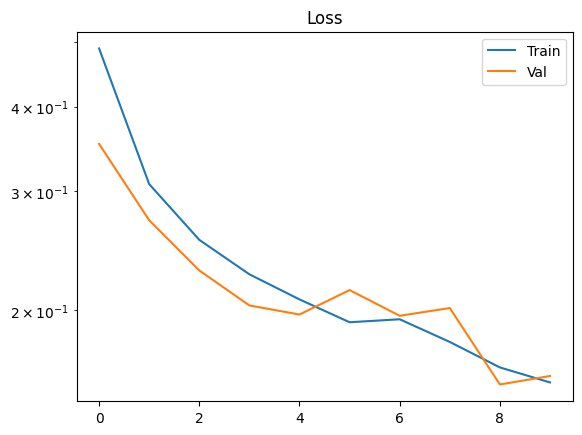

In [11]:
plt.figure()
plt.plot(combined_history[:,0], label="Train")
plt.plot(combined_history[:,1], label="Val")
plt.title('Loss')
plt.legend()
plt.yscale('log')
plt.savefig(out_path+"/Loss_Curve.png")
#plt.show()

In [12]:
# ### Evaluate Model

model.eval()

cumulative_loss_test = 0
cumulative_MSE_test = 0
cumulative_BCE_test = 0

Efrac_pred_labels = []
Efrac_true_labels = []

Mfrac_pred_labels = []
Mfrac_true_labels = []

trk_pred_labels = []
trk_true_labels = []

num_test = len(X_test)
for i in range(num_test):
    jet_pred, trk_pred = model(X_test[i][0].to(device), X_test[i][1].to(device), X_test[i][2].to(device))

    jet_loss=jet_loss_fn(jet_pred, y_test[i][0].to(device))
    trk_loss=trk_loss_fn(trk_pred, y_test[i][1].to(device))

    loss = jet_loss+trk_loss
    
    cumulative_loss_test+=loss.detach().cpu().numpy().mean()
    
    for j in range(jet_pred.shape[0]):
        Efrac_pred_labels.append(float(jet_pred[j][0].detach().cpu().numpy()))
        Efrac_true_labels.append(float(y_test[i][0][j][0].detach().numpy()))
        Mfrac_pred_labels.append(float(jet_pred[j][1].detach().cpu().numpy()))
        Mfrac_true_labels.append(float(y_test[i][0][j][1].detach().numpy()))

    for j in range(trk_pred.shape[0]):
        trk_pred_labels.append(float(trk_pred[j][0].detach().cpu().numpy()))
        trk_true_labels.append(float(y_test[i][1][j][0].detach().numpy()))
        
cumulative_loss_test = cumulative_loss_test / num_test

print("Train Loss:\t", combined_history[-1][0])
print("Val Loss:\t", combined_history[-1][1])
print("Test Loss:\t", cumulative_loss_test)
print()
print("Efrac MAE:\t", mean_absolute_error(Efrac_true_labels, Efrac_pred_labels))
print("Efrac RMSE:\t", root_mean_squared_error(Efrac_true_labels, Efrac_pred_labels))
print()
print("Mfrac MAE:\t", mean_absolute_error(Mfrac_true_labels, Mfrac_pred_labels))
print("Mfrac RMSE:\t", root_mean_squared_error(Mfrac_true_labels, Mfrac_pred_labels))

Train Loss:	 0.1563241
Val Loss:	 0.15977149
Test Loss:	 0.16940512

Efrac MAE:	 0.11303538754597389
Efrac RMSE:	 0.1721743910608757

Mfrac MAE:	 0.11890625383023226
Mfrac RMSE:	 0.15307528878583038


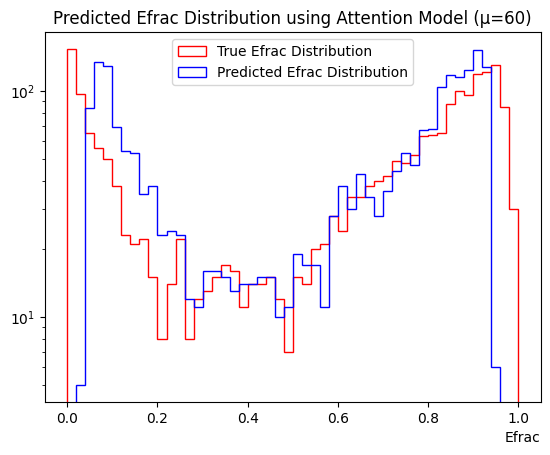

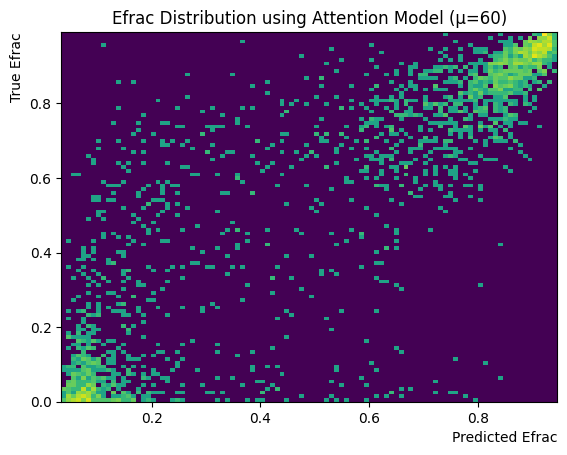

In [13]:
plt.figure()
plt.hist(Efrac_true_labels,histtype='step',color='r',label='True Efrac Distribution',bins=50,range=(0,1))
plt.hist(Efrac_pred_labels,histtype='step',color='b',label='Predicted Efrac Distribution',bins=50,range=(0,1))
plt.title("Predicted Efrac Distribution using Attention Model (\u03BC=60)")
plt.legend()
plt.yscale('log')
plt.xlabel('Efrac',loc='right')
plt.savefig(out_path+"/Efrac_1d.png")
#plt.show()

plt.figure()
plt.title("Efrac Distribution using Attention Model (\u03BC=60)")
plt.hist2d(Efrac_pred_labels,Efrac_true_labels, bins=100,norm=mcolors.PowerNorm(0.2))
plt.xlabel('Predicted Efrac',loc='right')
plt.ylabel('True Efrac',loc='top')
plt.savefig(out_path+"/Efrac_2d.png")
#plt.show()

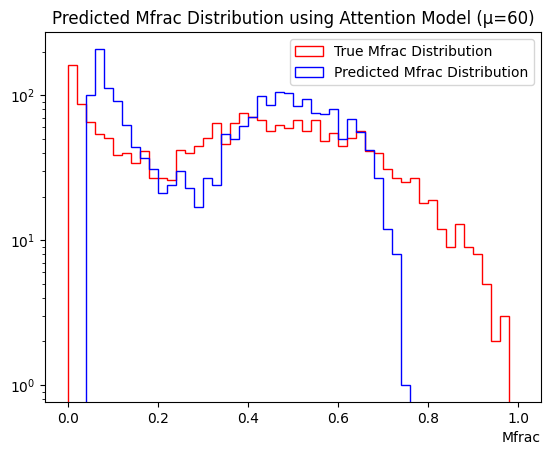

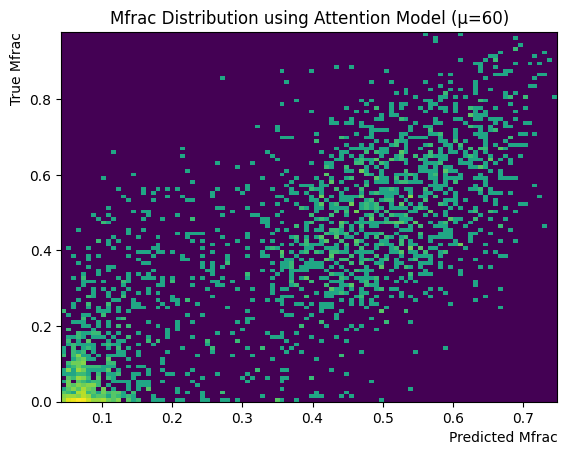

In [14]:
plt.figure()
plt.hist(Mfrac_true_labels,histtype='step',color='r',label='True Mfrac Distribution',bins=50,range=(0,1))
plt.hist(Mfrac_pred_labels,histtype='step',color='b',label='Predicted Mfrac Distribution',bins=50,range=(0,1))
plt.title("Predicted Mfrac Distribution using Attention Model (\u03BC=60)")
plt.legend()
plt.yscale('log')
plt.xlabel('Mfrac',loc='right')
plt.savefig(out_path+"/Mfrac_1d.png")
#plt.show()

plt.figure()
plt.title("Mfrac Distribution using Attention Model (\u03BC=60)")
plt.hist2d(Mfrac_pred_labels,Mfrac_true_labels, bins=100,norm=mcolors.PowerNorm(0.2))
plt.xlabel('Predicted Mfrac',loc='right')
plt.ylabel('True Mfrac',loc='top')
plt.savefig(out_path+"/Mfrac_2d.png")
#plt.show()

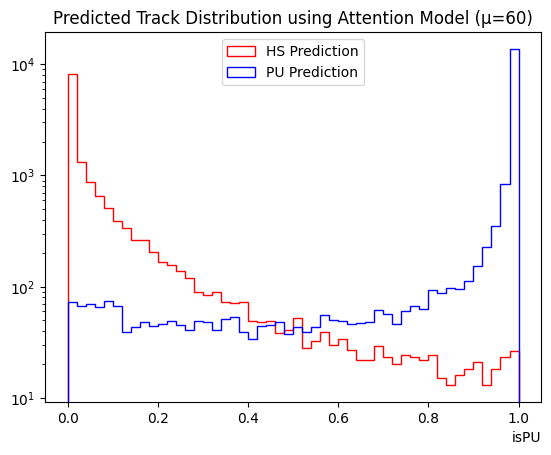

In [15]:
trk_true_labels = np.array(trk_true_labels)
trk_pred_labels = np.array(trk_pred_labels)

sig = trk_true_labels==0
bkg = ~sig

plt.figure()
plt.hist(trk_pred_labels[sig],histtype='step',color='r',label='HS Prediction',bins=50,range=(0,1))
plt.hist(trk_pred_labels[bkg],histtype='step',color='b',label='PU Prediction',bins=50,range=(0,1))
plt.title("Predicted Track Distribution using Attention Model (\u03BC=60)")
plt.legend()
plt.yscale('log')
plt.xlabel('isPU',loc='right')
plt.savefig(out_path+"/Trk_1d.png")
#plt.show()

In [16]:
def ATLAS_roc(y_true, y_pred):
    sig = (y_true==1)
    bkg = ~sig

    sig_eff = []
    bkg_eff = []

    thresholds = np.linspace(0,0.999,100)

    for threshold in thresholds:
        sig_eff.append(((y_pred[sig] > threshold).sum() / y_true[sig].shape[0]))
        bkg_eff.append(((y_pred[bkg] > threshold).sum()  / y_true[bkg].shape[0]))

    bkg_rej = [1/x for x in bkg_eff]
    return np.array(sig_eff), np.array(bkg_rej), thresholds

In [17]:
def roc(y_true, y_pred):
    sig = (y_true==1)
    bkg = ~sig

    sig_eff = []
    fake_rate = []

    thresholds = np.linspace(0,0.9,100)

    for threshold in thresholds:
        sig_eff.append(((y_pred[sig] > threshold).sum() / y_true[sig].shape[0]))
        fake_rate.append(((y_pred[bkg] > threshold).sum()  / y_true[bkg].shape[0]))

    return np.array(sig_eff), np.array(fake_rate), thresholds

In [18]:
def get_metrics(y_true, y_pred, threshold):
    y_Pred = np.array(y_pred > threshold).astype(int)
    y_True = np.array(y_true > threshold).astype(int)
    x1,y1, thresholds1 = ATLAS_roc(y_True, y_pred)
    x2,y2, thresholds2 = roc(y_True, y_pred)
    AUC = roc_auc_score(y_True, y_Pred)
    BA = accuracy_score(y_True, y_Pred)
    f1 = f1_score(y_True, y_Pred)
    return x1,y1,x2,y2,thresholds1,thresholds2,AUC,BA,f1

	Binary Accuracy:  0.9426849046788457 	F1 Score:  0.9466214483171365



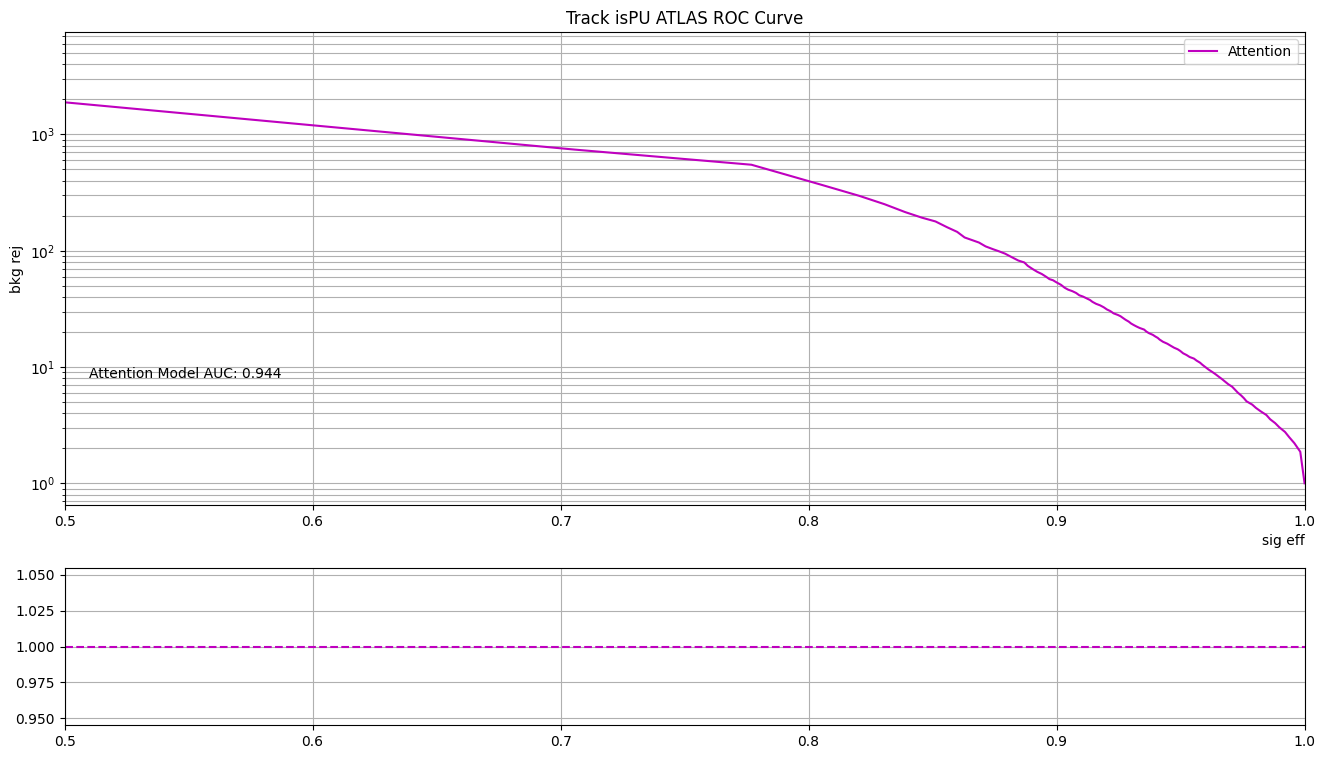

In [19]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,9), gridspec_kw={'height_ratios': [3, 1]})

x1,y1,x1_v2,y1_v2,th1,th1_v2,AUC1,BA1,f11 = get_metrics(np.array(trk_true_labels), np.array(trk_pred_labels), 0.5)

ax1.set_title("Track isPU ATLAS ROC Curve")
ax1.set_xlabel("sig eff",loc='right')
ax1.set_ylabel("bkg rej")

ax1.plot(x1,y1, label="Attention",color='m')
AUC1 = "Attention Model AUC: " + str(round(AUC1,4))
ax1.text(0.51,8,AUC1)

x = 1-np.flip(th1)
ratio1 = np.interp(x,np.flip(x1),np.flip(y1))/np.interp(x,np.flip(x1),np.flip(y1))
ax2.plot(x,ratio1,linestyle='--',color='m')

# General Plot Settings
ax1.legend()
ax1.set_yscale('log')
ax1.grid(which='both')
ax2.grid(which='both')
ax1.set_xlim(0.5,1)
ax2.set_xlim(0.5,1)
plt.savefig(out_path+"/Trk_ATLAS_ROC.png")
#plt.show()

print("\tBinary Accuracy: ", BA1, "\tF1 Score: ", f11)
print("")